# Solving Helmholtz equation

In this notebook, we seek to solve

$$ \mathcal{L}_\alpha u = i\alpha u  - L u = f $$

where $\alpha$ is a real-valued constant, $L$ is the grid Laplacian operator, and $u$ is a complex-valued field on the grid. It should be noted that $\alpha = \omega \Delta x^2/\nu$, where $\omega$ is a frequency, $\nu$ is kinematic viscosity, and $\Delta x$ is the grid spacing. The operator $\mathcal{L}_\alpha$ we will call the Helmholtz operator.

In [1]:
using Revise

In [2]:
using CartesianGrids

In [3]:
using Plots

In [3]:
?plan_helmholtz

search: plan_helmholtz plan_helmholtz!



```
plan_helmholtz(dims::Tuple,α::Number,[with_inverse=false],[fftw_flags=FFTW.ESTIMATE],
                      [factor=1.0],[dx=1.0])
```

Constructor to set up an operator for evaluating the discrete Helmholtz operator on complex dual or primal nodal data of dimension `dims`. If the optional keyword `with_inverse` is set to `true`, then it also sets up the inverse Helmholtz operator (the lattice Green's function, LGF). These can then be applied, respectively, with `*` and `\` operations on data of the appropriate size. The optional parameter `factor` is a scalar used to multiply the result of the operator and divide the inverse. The optional parameter `dx` is used in adjusting the uniform value of the LGF to match the behavior of the continuous analog at large distances; this is set to 1.0 by default.

Instead of the first argument, one can also supply `w::Nodes` to specify the size of the domain.

# Example


### Let's first plot the solution to the Helmholtz equation

In [4]:
α = 0.016
G = CartesianGrids.build_lgf_helmholtz(600,α);

┌ Info: Building and caching Helmholtz LGF table for α = 0.016
└ @ CartesianGrids /Users/jeff/JuliaProjects/CartesianGrids/src/gridoperations/lgf-helmholtz.jl:43
┌ Info: Switch to asymptotic formula at i = 148
└ @ CartesianGrids /Users/jeff/JuliaProjects/CartesianGrids/src/gridoperations/lgf-helmholtz.jl:47
┌ Info: Support radius = 351
└ @ CartesianGrids /Users/jeff/JuliaProjects/CartesianGrids/src/gridoperations/lgf-helmholtz.jl:50
Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


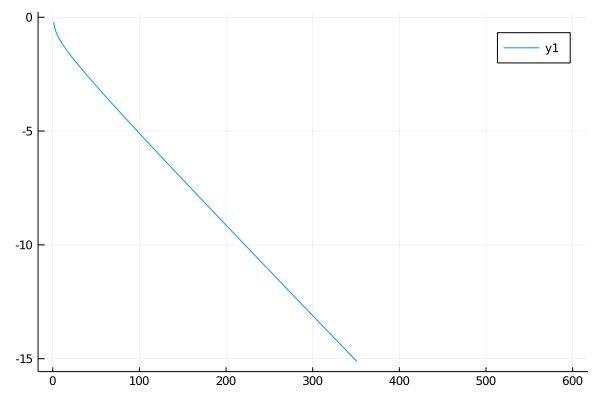

In [5]:
plot(log10.(abs.(G[1,1:end])))

### Now, another simple example
The Helmholtz operator can be endowed with an inverse. Here, we just want to verify that the inverse behaves as expected, recovering the original vector when we operate with the forward Helmholtz operator again.

In [88]:
nx = 12; ny = 12
α = 0.07
LH = plan_helmholtz(nx,ny,α;with_inverse=true)

cellunit = Nodes(Dual,(nx,ny),dtype=ComplexF64)
i = 5; j = 7
a = 2.0 + 5.0im
cellunit[i,j] = a

2.0 + 5.0im

In [89]:
ψ = LH\cellunit
@time helmψ = LH*ψ
helmψ[i,j]

  0.000023 seconds (6 allocations: 4.844 KiB)


2.000000000000001 + 5.000000000000002im

### An example problem
Here, we will solve the problem for viscous diffusion from a cylinder of radius $R$ oscillating rectilinearly with small amplitude and with frequency $\Omega$ in a viscous fluid. After Fourier-transforming in time, the leading-order mathematical problem is given by

$$ i \mathrm{Re} \hat{\omega} - \nabla^2 \hat{\omega} = 0, \qquad \hat{u}(x) = 1, \, \hat{v}(x) = 0,\quad x \in S $$

where the Reynolds number is $\mathrm{Re} = \Omega R^2/\nu$ and $S$ is the surface of the body (treated as stationary to leading order).

When we discretize on a Cartesian grid and immerse the body, the problem becomes

$$ \mathcal{L}_{\alpha} \hat{\omega} + C^T R f = 0$$
$$ -E C L^{-1} \hat{\omega} = 1 $$,

where $R$ and $E$ are the regularization and interpolation operators and $C^T$ and $C$ are the curl operators. We will solve this saddle-point problem with the help of the `ConstrainedSystems` and `RigidBodyTools` packages.

In [25]:
using ConstrainedSystems
using RigidBodyTools

[ Info: Precompiling ConstrainedSystems [c257ce95-4918-4279-a47c-50fdbcb74a04]
  ** incremental compilation may be fatally broken for this module **



In [26]:
?SaddleSystem

search: SaddleSystem



```
SaddleSystem
```

Construct a saddle-point system operator from the constituent operator blocks. The resulting object can be used with `*` and `\` to multiply and solve. The saddle-point problem has the form

$\begin{bmatrix}A & B_1^T \\ B_2 & C \end{bmatrix} \begin{pmatrix} u \\ f \end{pmatrix} = \begin{pmatrix} r_1 \\ r_2 \end{pmatrix}$

### Constructors

`SaddleSystem(A::AbstractMatrix,B₂::AbstractMatrix,B₁ᵀ::AbstractMatrix,C::AbstractMatrix[,eltype=Float64])`. Blocks are given as matrices. Must have consistent sizes to stack appropriately. If this is called with `SaddleSystem(A,B₂,B₁ᵀ)`, it sets `C` to zero automatically.

`SaddleSystem(A,B₂,B₁ᵀ,C,u,f[,eltype=Float64])`. Operators `A`, `B₂`, `B₁ᵀ`, `C` are given in various forms, including matrices, functions, and function-like objects. `u` and `f` are examples of the data types in the corresponding solution and right-hand side vectors. Guidelines:

  * The entries `A` and `B₂` must be able to act upon `u` (either by multiplication or as a function) and `B₁ᵀ` and `C` must be able to act on `f` (also, either by multiplication or as a function).
  * `A` and `B₁ᵀ` should return data of type `u`, and `B₂` and `C` should return data of type `f`.
  * `A` must be invertible and be outfitted with operators ``and`ldiv!`.
  * Both `u` and `f` must be subtypes of `AbstractArray`: they must be equipped with `size` and `vec` functions and with a constructor of the form `T(data)` where `T` is the data type of `u` or `f` and `data` is the wrapped data array.

If called as `SaddleSystem(A,B₂,B₁ᵀ,u,f)`, the `C` block is omitted and assumed to be zero.

If called with `SaddleSystem(A,u)`, this is equivalent to calling `SaddleSystem(A,nothing,nothing,u,[])`, then this reverts to the unconstrained system described by operator `A`.

The list of vectors `u` and `f` in any of these constructors can be bundled together as a [`SaddleVector`](@ref), e.g. `SaddleSystem(A,B₂,B₁ᵀ,SaddleVector(u,f))`.

An optional keyword argument `solver=` can be used to specify the type of solution for the Schur complement system. By default, this is set to `Direct`, and the Schur complement matrix is formed, factorized, and stored. This can be changed to `Iterative`, in which case an iterative solver is determined by the `linsolve` function of [`KrylovKit.jl`](https://github.com/Jutho/KrylovKit.jl).


In [27]:
Re = 40
Δx = 0.02
xlim = (-5.98,5.98)
ylim = (-5.98,5.98)
g = PhysicalGrid(xlim,ylim,Δx)
nx, ny = size(g)

(600, 600)

In [20]:
α = Re*Δx^2

0.016

In [21]:
LH = plan_helmholtz(nx,ny,α;with_inverse=true)

[ Info: Building and caching Helmholtz LGF table for α = 0.016
[ Info: Switch to asymptotic formula at i = 148
[ Info: Support radius = 351


Discrete Helmholtz operator (and inverse) on a (nx = 600, ny = 600) grid with factor 1.0 + 0.0im and spacing 1.0

In [28]:
w1 = Nodes(Dual,size(g),dtype=ComplexF64)
q1 = Edges(Primal,w1,dtype=ComplexF64)
n = 150
body = Circle(1.0,n)
X = VectorData(collect(body))
f = VectorData(X,dtype=ComplexF64);

Set up operators for the constraint operators

In [29]:
L = plan_laplacian(nx,ny;with_inverse=true,dtype=ComplexF64)

Discrete Laplacian (and inverse) on a (nx = 600, ny = 600) grid acting on ComplexF64 data with
               factor 1.0 + 0.0im and spacing 1.0

In [30]:
regop = Regularize(X,Δx,I0=origin(g),issymmetric=true)
H, E = RegularizationMatrix(regop,f,q1)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

The constraint operators

In [31]:
B₁ᵀ(f::VectorData{N,T}) where {N,T<:ComplexF64} = Curl()*(H*f)
B₂(w::Nodes{Dual,NX,NY,T}) where {NX,NY,T<:ComplexF64} = -(E*(Curl()*(L\w)))

B₂ (generic function with 1 method)

In [33]:
@time S1 = SaddleSystem(LH,B₂,B₁ᵀ,SaddleVector(w1,f),eltype=ComplexF64)

 14.317369 seconds (64.38 k allocations: 14.297 GiB, 2.50% gc time)


Saddle system with 360000 states and 296 constraints and
   State vector of type Nodes{Dual, 600, 600, ComplexF64, Matrix{ComplexF64}}
   Constraint vector of type VectorData{148, ComplexF64, Vector{ComplexF64}}
   Elements of type ComplexF64
using a Direct solver


In [35]:
# Set up the right-hand side
rhs1 = deepcopy(f)
fill!(rhs1.u,1.0)
fill!(rhs1.v,0.0)
rhs = (zero(w1),rhs1)

# Solve it
@time w1, f = S1\rhs

# and find the streamfunction
s1 = -Δx*real(L\w1);

  0.070210 seconds (334 allocations: 60.427 MiB)


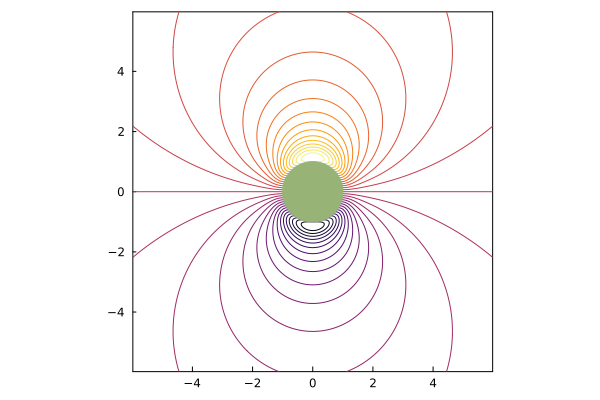

In [36]:
xg, yg = coordinates(w1,g)
plot(xg,yg,s1,levels=range(-1,1,length=31),xlim=xlim,ylim=ylim)
plot!(body)